<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-data" data-toc-modified-id="Input-data-1">Input data</a></span></li><li><span><a href="#Key-Components-of-an-AB-Test" data-toc-modified-id="Key-Components-of-an-AB-Test-2">Key Components of an AB Test</a></span><ul class="toc-item"><li><span><a href="#Running-an-AB-test-in-✨abracadabra✨-is-as-easy-as-✨1,-2,-3✨:" data-toc-modified-id="Running-an-AB-test-in-✨abracadabra✨-is-as-easy-as-✨1,-2,-3✨:-2.1">Running an AB test in ✨abracadabra✨ is as easy as ✨1, 2, 3✨:</a></span><ul class="toc-item"><li><span><a href="#Hypotheses" data-toc-modified-id="Hypotheses-2.1.1">Hypotheses</a></span></li><li><span><a href="#Inference-Methods" data-toc-modified-id="Inference-Methods-2.1.2">Inference Methods</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-2.1.3">Example</a></span></li></ul></li></ul></li><li><span><a href="#Interpreting-results" data-toc-modified-id="Interpreting-results-3">Interpreting results</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Top-Plot:-Sample-Distributions" data-toc-modified-id="Top-Plot:-Sample-Distributions-3.0.1">Top Plot: Sample Distributions</a></span></li><li><span><a href="#Middle-Plot:-Central-Tendencies" data-toc-modified-id="Middle-Plot:-Central-Tendencies-3.0.2">Middle Plot: Central Tendencies</a></span></li><li><span><a href="#Bottom-Plot:-Deltas" data-toc-modified-id="Bottom-Plot:-Deltas-3.0.3">Bottom Plot: Deltas</a></span></li></ul></li></ul></li><li><span><a href="#Including-Segmentations" data-toc-modified-id="Including-Segmentations-4">Including Segmentations</a></span></li><li><span><a href="#Running-multiple-tests,-and-multiple-comparison-control" data-toc-modified-id="Running-multiple-tests,-and-multiple-comparison-control-5">Running multiple tests, and multiple comparison control</a></span></li><li><span><a href="#Custom-Metrics" data-toc-modified-id="Custom-Metrics-6">Custom Metrics</a></span></li><li><span><a href="#Bayesian-Hypothesis-Tests" data-toc-modified-id="Bayesian-Hypothesis-Tests-7">Bayesian Hypothesis Tests</a></span><ul class="toc-item"><li><span><a href="#Bayesian-Model-Specification" data-toc-modified-id="Bayesian-Model-Specification-7.1">Bayesian Model Specification</a></span></li></ul></li><li><span><a href="#Working-with-other-types-of-variables" data-toc-modified-id="Working-with-other-types-of-variables-8">Working with other types of variables</a></span><ul class="toc-item"><li><span><a href="#Continuous-Variables" data-toc-modified-id="Continuous-Variables-8.1">Continuous Variables</a></span><ul class="toc-item"><li><span><a href="#Bayesian-models-for-continuous-variables" data-toc-modified-id="Bayesian-models-for-continuous-variables-8.1.1">Bayesian models for continuous variables</a></span></li></ul></li><li><span><a href="#Counts-/-Rates-variables" data-toc-modified-id="Counts-/-Rates-variables-8.2">Counts / Rates variables</a></span><ul class="toc-item"><li><span><a href="#Bayesian-models-for-count-variables" data-toc-modified-id="Bayesian-models-for-count-variables-8.2.1">Bayesian models for count variables</a></span></li></ul></li></ul></li></ul></div>

# ✨abracadabra✨ Basics

## Input data
✨abracadabra✨ takes as input a `pandas` `DataFrame` containing experiment observations data. Each record in the DataFrame represents an observation trial recorded in the experiment, and has the following columns:

- One or more `metric` columns: these are the values associated with each observation that are used to compare the two groups in the experiment.
- One or more `treatment` columns: each treatment column contains two or more distinct, discrete values that are used to identify the different groups in the experiment
- Zero or more columns that are associated with additional `attributes` assigned to the observations. These attributes can be used for any additional segmentations across experiment groups.

Below we use the `generate_fake_observations` utility function to create a dataset of artificial experiment observations.

In [1]:
from abra.utils import generate_fake_observations

# generate some fake binary trial data
binary_data = generate_fake_observations(
    distribution='bernoulli',  # binary data
    n_treatments=3,
    n_attributes=4,
    n_observations=1000
)
binary_data.head()

,id,treatment,attr_0,attr_1,attr_2,attr_3,metric
0,0,C,A0a,A1a,A2b,A3a,True
1,1,B,A0a,A1a,A2b,A3a,True
2,2,C,A0a,A1b,A2c,A3a,True
3,3,C,A0a,A1a,A2a,A3a,False
4,4,A,A0a,A1b,A2a,A3a,True


The resulting data have a single `treatment` column, called (creatively) `'treatment'`, a single `metric` column, called `'metric'`, and four `attribute` columns, `atr_0`, `attr_1`, `attr_2`, and `attr_3`. The `treatment` column has 3 distinct treatments: `"A"`, `"B"`, and `"C"`, and the metric takes on boolean/binary values drawn from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).

## Key Components of an AB Test

The three key components of running an AB test in ✨abracadabra✨ are:

- The `Experiment`, which holds the raw observations data recorded from, and any metadata associated with an AB experiment.
- The `HypothesisTest`, which defines the statistical inference procedure applied to the experiment data.
- The `HypothesisTestResults`, which is the statistical artifact that results from running a `HypothesisTest` against an `Experiment`'s observations. The `HypothesisTestResults` are used to summarize, visulize, and interpret the inference results and make decisions based on these results.

### Running an AB test in ✨abracadabra✨ is as easy as ✨1, 2, 3✨:
1. Initialize your `Experiment` with observations and any metadata
2. Define your `HypothesisTest`. This requires defining the `hypothesis` and `inference_method`. The relevant inference method used will depend on the support of your observations. A list of supported hypotheses and inference methods for different types of observation variables are shown below:

#### Hypotheses
| Hypothesis | Hypothesis Type | `hypothesis` parameter  |
|---|---|---|
| "The treatment is larger than the control" | one-tailed | `"larger"` |
| "The treatment is smaller than the control" | one-tailed | `"smaller"` |
| "The treatment is not equal to the control" | two-tailed | `"unequal"` |


#### Inference Methods

| Variable Type | Model Class| `inference_method` parameter  |
|---|---|---|
| Continuous | Frequentist| `'means_delta'` (t-test) |
|  | Bayesian| `'gaussian'`, `'exp_student_t'`|
| Binary / Proportions | Frequentist| `'proportions_delta'` (z-test) |
|  | Bayesian| `'beta'`, `'beta_binomial'`, `'bernoulli'`  |
| Counts  |Frequentist| `'rates_ratio'`  |
|  |Bayesian| `'gamma_poisson'`  |

3. Run the test against your experiment and interpret the resulting `HypothesisTestResults`

#### Example

Below we demonstrate a standard AB test workflow in ✨abracadabra✨. Namely we:
1. Initialize an `Experiment` instance `exper` with our artifical binary observations generated above.
2. We then initialize a `HypothesisTest` instance `ab_test` that tests if `treatment` `"B"` is `"larger"` than treatment `"A"` based on the metric values in the `"metric"` column of the dataframe. The hypothesis test uses a Frequentist method `'proportions_delta'` that is dedicated to detecting differences between binary samples. 

In [2]:
from abra import Experiment, HypothesisTest

# Initialize the Experiment
exper = Experiment(data=binary_data, name="Demo Experiment")

# Initialize the A/B test
ab_test = HypothesisTest(
    metric="metric",
    treatment="treatment",
    control="A", variation="B",
    hypothesis="unequal",
    inference_method="proportions_delta"
)

# Run the test with an alpha of 0.5; get back a HypothesisTestResults object
ab_test_results = exper.run_test(ab_test, alpha=.05)

# Check the test results decision
assert ab_test_results.accept_hypothesis

## Interpreting results
Each `HypothesisTestResults` has its own `display()` and `visualize()` methods that can be used to interpret the results of the test. The `display()` method prints out the results to the console, while `visualize` plots a visual summary of the results.

In [3]:
# Print the test results to the console
ab_test_results.display()


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 318              | 345             |
| Mean           | 0.4528           | 0.5594          |
| Standard Error | (0.3981, 0.5075) | (0.507, 0.6118) |
| Variance       | 0.2478           | 0.2465          |
+----------------+------------------+-----------------+

Test Results:
+---------------------------+---------------------+
| ProportionsDelta          | 0.1066              |
| ProportionsDelta CI       | (0.0307, 0.1824)    |
| CI %-tiles                | (0.0250, 0.9750)    |
| ProportionsDelta-relative | 23.54 %             |
| CI-relative               | (6.79, 40.29) %     |
| Effect Size               | 0.2144              |
| alpha                     | 0.0500              |
| Power                     | 0.7877      

Providing an `outfile` argument to the `visualize` method will save the results figure to an image file.

Populating the interactive namespace from numpy and matplotlib
-rw-r--r--@ 1 dustinstansbury  wheel    27K Jun  3 20:18 /tmp/abracadabra_demo_test_results.png


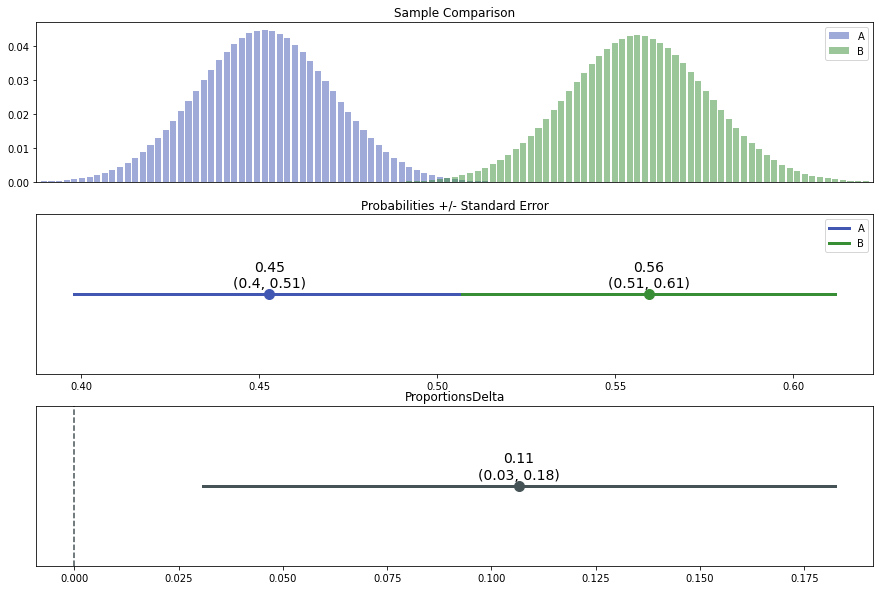

In [4]:
%pylab inline
# Visualize the test results
outfile = '/tmp/abracadabra_demo_test_results.png'
ab_test_results.visualize(outfile=outfile)

# Show that results figure exists
!ls -lah {outfile}

The resulting frequentist test results (displayed and visualized above) indicate that hypothesis `"B != A"` should be accepted. A breakdown of the results plot is as follows:

#### Top Plot: Sample Distributions
The top plot compares the _parameterized representation of the sample distributions_ with parameters being derived from the experiment observations.

The large degree of separation between the two distributions indicates that the `"B"` group is qualitatively larger than `"A"`

#### Middle Plot: Central Tendencies
The middle plot compares the _central tendiency estimates_ of the two sample groups--in this case the, average probability of success on a given trial--as well as adds _Standard Errors_ calculate for the central tendency estimates.

We can see that there is no overlap of the standard errors, further indicating that we can be confident that the two groups are likely different, and that `"B"` is larger than `"A"`.

#### Bottom Plot: Deltas
The bottom plot gives the estimate of the _difference in central tendencies_, in this case `ProportionsDelta`, as well as 95% Confidence Intervals on this difference estimate (This is a two-tailed test, checking that `"B"` is not equal to `"A"`, so the upper bound on ProportionsDelta is `inf`).

We can see that the confidence interval on the difference between the two groups does not intersect with the `ProportionsDelta=0` line, indicating a statistically significant difference between the two samples.

## Including Segmentations
✨abracdabra✨ supports the ability to segment experiment observations based on one or more attributes in your dataset using the `segmentation` argument to `HyptothesisTest`. The segmentation can be a string or list of string expressions, each of which follow the [pandas query API](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.query.html)


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 97               | 101             |
| Mean           | 0.5258           | 0.5842          |
| Standard Error | (0.4264, 0.6251) | (0.488, 0.6803) |
| Variance       | 0.2493           | 0.2429          |
+----------------+------------------+-----------------+

Test Results:
+---------------------------+---------------------+
| ProportionsDelta          | 0.0584              |
| ProportionsDelta CI       | (-0.0582, inf)      |
| CI %-tiles                | (0.0500, inf)       |
| ProportionsDelta-relative | 11.10 %             |
| CI-relative               | (-11.07, inf) %     |
| Effect Size               | 0.1177              |
| alpha                     | 0.0500              |
| Power                     | 0.2070      

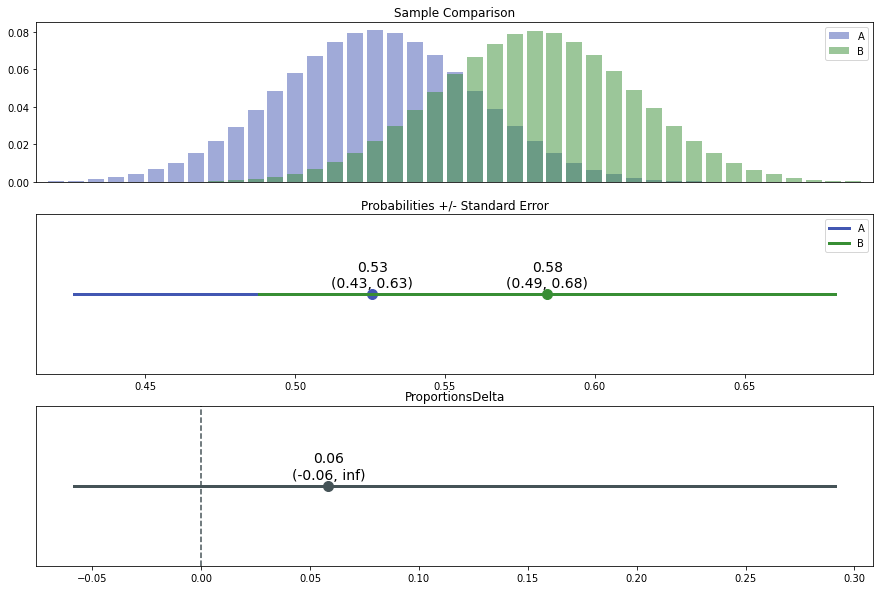

In [5]:
# Initialize an A/B test with additional segmentation on the 'attr_1' attribute
ab_test_segmented = HypothesisTest(
    metric='metric',
    control='A', variation='B',
    inference_method='proportions_delta',
    hypothesis='larger',
    segmentation="attr_1 == 'A1a'"
)

# Run the segmented test
ab_test_segmented_results = exper.run_test(ab_test_segmented)
assert not ab_test_segmented_results.accept_hypothesis  # B is larger

# Display results (notice reduced sample sizes)
ab_test_segmented_results.display()
ab_test_segmented_results.visualize()

We now see that if we dig into a particular segment, namely the segement defined by `"attr_1 == 'A1a'"`, we can no longer accept the hypothesis that `"B is larger"`. This is indicated by a `ProportionsDelta` that overlaps substantially with the line indicating `0` difference between the two samples.

## Running multiple tests, and multiple comparison control
When running multiple tests on the same metric, you'll need to control for [multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). This is handled by running a `HypothesisTestSuite`, which takes in a list of hypothesis tests.

Below we run 3 independent tests comparing A to A, B to A and C to A, and set the correction `method` to `'bonferonni'`, which simply updates the effective $\alpha_{corrected} = \frac{\alpha}{N_{tests}}$. Our original value for `alpha=0.05`, thus the corrected value would be $\frac{0.05}{3} = 0.0167$

In [6]:
from abra.hypothesis_test import HypothesisTestSuite
from copy import deepcopy

# Use the `HypothesisTest.copy` method for duplicating test
# configurations, while overwriting specific parameters, in
# this case `variation` parameter
aa_test = ab_test.copy(variation='A')
ac_test = ab_test.copy(variation='C')

# Initialize the `HypothesisTestSuite`
test_suite = HypothesisTestSuite(
    tests=[aa_test, ab_test, ac_test],
    correction_method='bonferroni'
)

# Run tests
test_suite_results = exper.run_test_suite(test_suite)

print(test_suite_results)

# Print results
test_suite_results.display()

HypothesisTestSuiteResults(ntests=3, correction_method='bonferroni')
------------------------------------------------------------
Test 1 of 3

Observations Summary:
+----------------+-----------------+-----------------+
| Treatment      | A               | A               |
+----------------+-----------------+-----------------+
| Metric         | metric          | metric          |
| Observations   | 318             | 318             |
| Mean           | 0.4528          | 0.4528          |
| Standard Error | (0.386, 0.5197) | (0.386, 0.5197) |
| Variance       | 0.2478          | 0.2478          |
+----------------+-----------------+-----------------+

Test Results:
+---------------------------+---------------------+
| ProportionsDelta          | 0.0000              |
| ProportionsDelta CI       | (-0.0841, inf)      |
| CI %-tiles                | (0.0167, inf)       |
| ProportionsDelta-relative | 0.00 %              |
| CI-relative               | (-18.58, inf) %     |
| Effect Size

Note that the alpha has been `corrected` with `MC Correction='bonferroni'`

In [7]:
# test_suite_results.visualize()

The `HypothesisTestSuite` supports the following multiple comparison strategies:
- [Sidak](http://en.wikipedia.org/wiki/%C5%A0id%C3%A1k_correction) (default)
- [Bonferonni](http://en.wikipedia.org/wiki/Bonferroni_correction)
- [Benjamini-Hochberg false-discovery rate](http://pdfs.semanticscholar.org/af6e/9cd1652b40e219b45402313ec6f4b5b3d96b.pdf)

## Custom Metrics
✨abracadabra✨ also supports the use of custom metrics, which can transform and combine information from one or more columns. Below we create a `CustomMetric` always makes the `variation` greater than the `control` by adding a constant offset (plus noise) to the value of the the `control`.

In [8]:
from abra import CustomMetric
import numpy as np

def custom_metric(row):
    """
    Define a custom 'metric' where the control is always better.
    """
    return 4 + np.random.rand() if row['treatment'] == 'A' else np.random.rand()

custom_test = HypothesisTest(
    metric=CustomMetric(custom_metric),
    control='A',
    variation='B',
    inference_method='means_delta',  # Note we use a t-test here
    hypothesis='unequal'
)

custom_test = exper.run_test(custom_test)
custom_test.display()


Observations Summary:
+----------------+-----------------+-----------------+
| Treatment      | A               | B               |
+----------------+-----------------+-----------------+
| Metric         | custom_metric   | custom_metric   |
| Observations   | 318             | 345             |
| Mean           | 4.4751          | 0.5239          |
| Standard Error | (4.4442, 4.506) | (0.493, 0.5547) |
| Variance       | 0.0791          | 0.0854          |
+----------------+-----------------+-----------------+

Test Results:
+----------------------+--------------------+
| MeansDelta           | -3.9512            |
| MeansDelta CI        | (-3.9949, -3.9075) |
| CI %-tiles           | (0.0250, 0.9750)   |
| MeansDelta-relative  | -88.29 %           |
| CI-relative          | (-89.27, -87.32) % |
| Effect Size          | -13.7631           |
| alpha                | 0.0500             |
| Power                | 1.0000             |
| Inference Method     | 'means_delta'      |
| Test 

We see that, as expected, we have highly significant results, accepting the hypothesis that `'B != A'`

## Bayesian Hypothesis Tests
In addition to common Frequentist test, running Bayesian analogs is simple. Simply intitialize the `HypothesisTest` with a Bayesian `method` parameter. For example, the Bayesian analogs to the `'proportions_delta'` method are the `'binomial'`, `'beta_binomial'`, or `'bernoulli'` methods.


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 318              | 345             |
| Mean           | 0.4528           | 0.5594          |
| Standard Error | (0.3981, 0.5075) | (0.507, 0.6118) |
| Variance       | 0.2478           | 0.2465          |
+----------------+------------------+-----------------+

Test Results:
+------------------------+-------------------------------+
| Delta                  | 0.1057                        |
| HDI                    | (0.0344, 0.1853)              |
| HDI %-tiles            | (0.0500, 0.9500)              |
| Delta-relative         | 23.79 %                       |
| HDI-relative           | (5.91, 43.62) %               |
| Effect Size            | 0.2133                        |
| alpha                  | 0.0500            

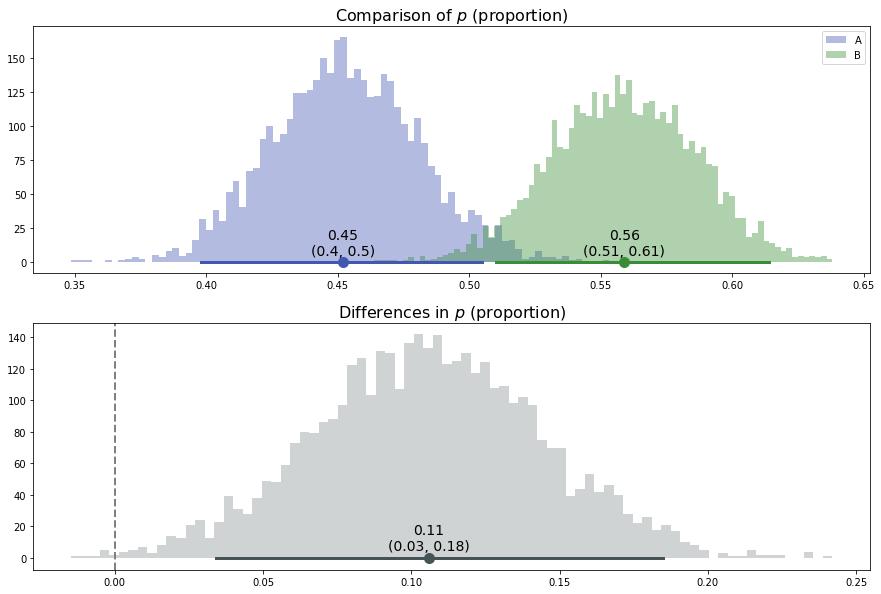

In [9]:
# set up Bayesian A/B test with default priors
binomial_ab_test = HypothesisTest(
    metric='metric',
    control='A',
    variation='B',
    inference_method='binomial'
)

# run the test
binomial_ab_test_results = exper.run_test(binomial_ab_test)
assert binomial_ab_test_results.prob_greater > .95
binomial_ab_test_results.display()
binomial_ab_test_results.visualize()

Bayesian `HypothesisTestResults` have their own analogous `display` and `visualize` methods that can be used to interpret the results of the analysis. Notice the results of the `ab_test_results` and `binomial_ab_test_results` each support a difference in proportions of approximately 0.14.

### Bayesian Model Specification
Bayesian models allow the experimenter to incorporate prior beliefs. This can be helpful when you have little data, or have strong domain knowledge of baselines. Specifying custom priors is also straight-forward using `abracadaba`, simply pass in a a `model_params` argument during `HypothesisTest` initialization:


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 318              | 345             |
| Mean           | 0.4528           | 0.5594          |
| Standard Error | (0.3981, 0.5075) | (0.507, 0.6118) |
| Variance       | 0.2478           | 0.2465          |
+----------------+------------------+-----------------+

Test Results:
+------------------------+-------------------------------+
| Delta                  | 0.1057                        |
| HDI                    | (0.0344, 0.1853)              |
| HDI %-tiles            | (0.0500, 0.9500)              |
| Delta-relative         | 23.79 %                       |
| HDI-relative           | (5.91, 43.62) %               |
| Effect Size            | 0.2133                        |
| alpha                  | 0.0500            

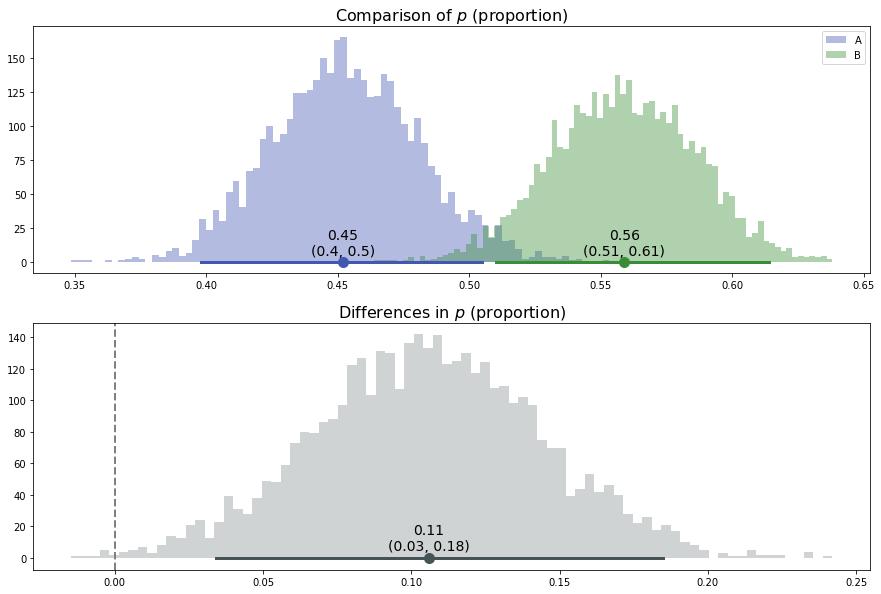

In [10]:
# Run Bayesian test with custom priors
beta_prior_params = dict(alpha=100., beta=100.)  # strong prior at p = .5
bb_ab_test = HypothesisTest(
    metric='metric',
    control='A', variation='C',
    inference_method='beta_binomial',
    model_params=beta_prior_params
)

# run the test
binomial_ab_test_results = exper.run_test(binomial_ab_test)
assert binomial_ab_test_results.prob_greater > .95
binomial_ab_test_results.display()
binomial_ab_test_results.visualize()

## Working with other types of variables
The examples above demonstrate running AB tests for variables that take on binary values--i.e. variables that take on values that exist in the interval $[0, 1]$. This is a pretty common scenario, as a lot of AB tests measure metrics like conversions at various stages in a UX funnel. However, ✨abracadabra✨ also supports inference methods for other types of variables, like continuous variables (e.g. time spent on a page) and counts/rate variables (e.g. number of clicks on a button per unit time).

### Continuous Variables
Many continuous variables follow Gaussian distribution, thus deltas between samples of continuous variables are often modeled based on differences of Gaussian-distributed random variables. The most common statistical inference for this scenario is the good ole' [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), referred to in ✨abracadabra✨ as `"means_delta"`, as it tests for differences in means of the underlying Gaussian distributions from each of treatments.

Below we generate some Gaussian-distributed observations and show how ✨abracadabra✨can be used to run a t-test using the common `Experiment->HypothesisTest->HypothesisTestResults` workflow.

In [11]:
# generate some fake Gaussian-distributed trial data
gaussian_data = generate_fake_observations(
    distribution='gaussian',  # binary data
    n_treatments=3,
    n_attributes=4,
    n_observations=1000
)
gaussian_data.head()

,id,treatment,attr_0,attr_1,attr_2,attr_3,metric
0,0,C,A0a,A1a,A2b,A3a,1.864791
1,1,B,A0a,A1a,A2b,A3a,1.459872
2,2,C,A0a,A1b,A2c,A3a,1.565319
3,3,C,A0a,A1a,A2a,A3a,1.255146
4,4,A,A0a,A1b,A2a,A3a,1.996133


Here we use the `inference_method="means_delta"` argument to run the t-test


Observations Summary:
+----------------+-------------------+------------------+
| Treatment      | A                 | B                |
+----------------+-------------------+------------------+
| Metric         | metric            | metric           |
| Observations   | 318               | 345              |
| Mean           | -0.0415           | 1.0831           |
| Standard Error | (-0.1526, 0.0697) | (0.9792, 1.1871) |
| Variance       | 1.0227            | 0.9711           |
+----------------+-------------------+------------------+

Test Results:
+----------------------+------------------------+
| MeansDelta           | 1.1246                 |
| MeansDelta CI        | (0.9722, 1.2771)       |
| CI %-tiles           | (0.0250, 0.9750)       |
| MeansDelta-relative  | 2710.18 %              |
| CI-relative          | (-2342.83, -3077.53) % |
| Effect Size          | 1.1270                 |
| alpha                | 0.0500                 |
| Power                | 1.0000         

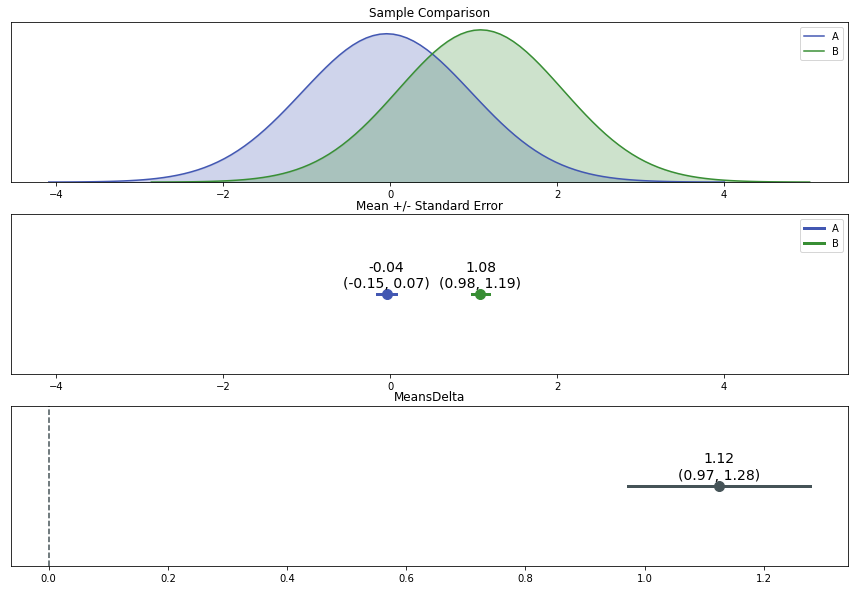

In [12]:
# Initialize the Experiment
exper = Experiment(data=gaussian_data, name="Demo Experiment")

# Initialize the A/B test
gaussian_ab_test = HypothesisTest(
    metric="metric",
    treatment="treatment",
    control="A", variation="B",
    hypothesis="unequal",
    inference_method="means_delta"
)

# Run the test with an alpha of 0.5; get back a HypothesisTestResults object
gaussian_ab_test_results = exper.run_test(gaussian_ab_test, alpha=.05)

# Check the test results decision
assert gaussian_ab_test_results.accept_hypothesis
gaussian_ab_test_results.display()
gaussian_ab_test_results.visualize()

#### Bayesian models for continuous variables
The Bayesian analog to the t-test is called the "Hierarchical Gaussian" and involves modeling the observations as a generative process where each point is sampled from a Gaussian distribution with mean $\mu$ and variance $\sigma^2$. The model is "hierarchical" because it also assumes there is a distribution over both $\mu$ and $\sigma^2$ as well, namely $\mu \sim \text{Normal}(\bar{x}, \text{std(x)})$ and $\sigma \sim \text{Uniform}(0, \sigma_{max})$, where $\bar{x}$ and  $\text{std(x)}$ are the empirical mean and standard deviation of the observations, and $\sigma_{max}$ is a user-specified hyperparameter.


That all sounds pretty complicated, right? Well, in ✨abracadabra✨ it's easy to run inference using this model. We simply update the `inference_method`:


Observations Summary:
+----------------+-------------------+------------------+
| Treatment      | A                 | B                |
+----------------+-------------------+------------------+
| Metric         | metric            | metric           |
| Observations   | 318               | 345              |
| Mean           | -0.0415           | 1.0831           |
| Standard Error | (-0.1526, 0.0697) | (0.9792, 1.1871) |
| Variance       | 1.0227            | 0.9711           |
+----------------+-------------------+------------------+

Test Results:
+------------------------+-------------------------+
| Delta                  | 1.1245                  |
| HDI                    | (0.9650, 1.2774)        |
| HDI %-tiles            | (0.0500, 0.9500)        |
| Delta-relative         | -7002.98 %              |
| HDI-relative           | (-24826.12, 21963.50) % |
| Effect Size            | 1.1206                  |
| alpha                  | 0.0500                  |
| Credible Mass 

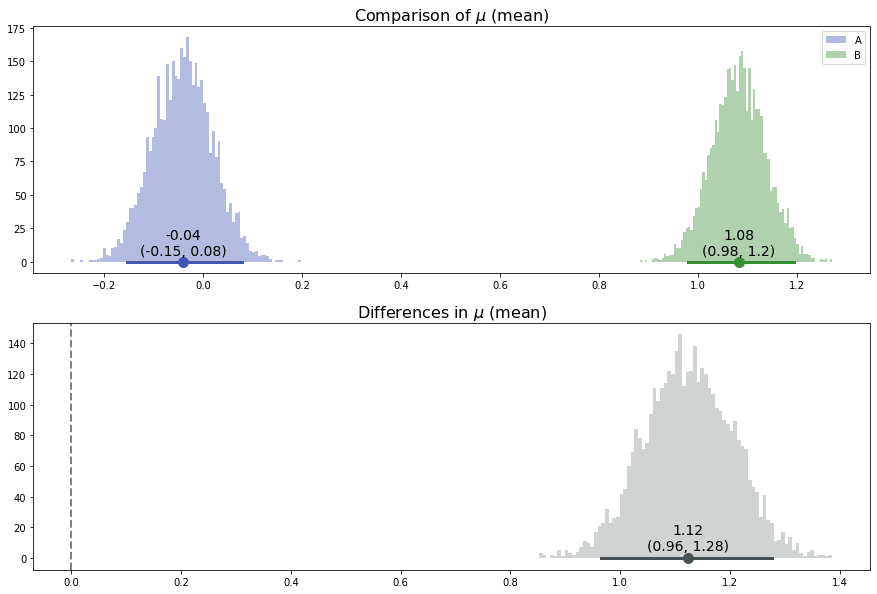

In [13]:
bayesian_gaussian_ab_test = ab_test.copy(inference_method='gaussian')

# Run the test with an alpha of 0.5; get back a HypothesisTestResults object
bayesian_gaussian_ab_test_results = exper.run_test(bayesian_gaussian_ab_test, alpha=.05)

# Check the test results decision
assert bayesian_gaussian_ab_test_results.accept_hypothesis
bayesian_gaussian_ab_test_results.display()
bayesian_gaussian_ab_test_results.visualize()


### Counts / Rates variables
✨abracadabra✨ also supports analysis of counts variables such as clicks or page views per unit time. These discrete, countable variables often follow a Poisson distribution. Rather than modeling the _difference_ between the two treatments, we instead model whether the ratio of the two counts is statistically different than 1. The reasoning being that if the two treatments have the same number of counts per the same unit of time (and thus the same _rate_) then their ratio will be close to unity. Accordingly, in ✨abracadabra✨, this is called a `"rates_ratio"` inference method.

Below we'll run an AB test on syntetic data drawn from a Poisson distribution, and test to see if the two distributions are statistically different.

In [26]:
# generate some fake Gaussian-distributed trial data
counts_data = generate_fake_observations(
    distribution='poisson',  # binary data
    n_treatments=3,
    n_observations=1000
)
counts_data.head()

,id,treatment,attr_0,attr_1,metric
0,0,C,A0a,A1a,8.0
1,1,B,A0a,A1a,1.0
2,2,C,A0a,A1b,1.0
3,3,C,A0a,A1a,5.0
4,4,A,A0a,A1b,3.0



Observations Summary:
+----------------+------------------+------------------+
| Treatment      | B                | C                |
+----------------+------------------+------------------+
| Metric         | metric           | metric           |
| Observations   | 345              | 337              |
| Mean           | 1.9768           | 3.0119           |
| Standard Error | (1.8345, 2.1192) | (2.8222, 3.2016) |
| Variance       | 1.8198           | 3.1571           |
+----------------+------------------+------------------+

Test Results:
+----------------------+------------------+
| RatesRatio           | 1.5236           |
| RatesRatio CI        | (1.3826, 1.6787) |
| CI %-tiles           | (0.0250, 0.9750) |
| RatesRatio-relative  | 152.36 %         |
| CI-relative          | (69.94, 84.92) % |
| Effect Size          | 0.3121           |
| alpha                | 0.0500           |
| Power                | 1.0000           |
| Inference Method     | 'rates_ratio'    |
| Test St

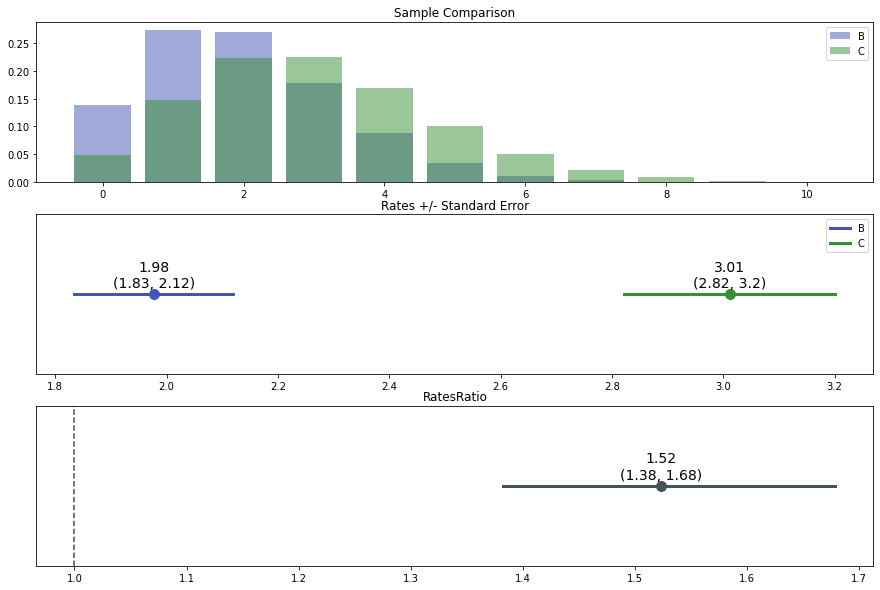

In [31]:
# Initialize the A/B test
exper = Experiment(data=counts_data, name="Demo Experiment")

poisson_ab_test = HypothesisTest(
    metric="metric",
    treatment="treatment",
    control="B", variation="C",
    hypothesis="unequal",
    inference_method="rates_ratio"
)

# Run the test with an alpha of 0.5; get back a HypothesisTestResults object
poisson_ab_test_results = exper.run_test(poisson_ab_test, alpha=.05)

# Check the test results decision
poisson_ab_test_results.display()
poisson_ab_test_results.visualize()

Here we can see that the ratio of the two rate parameters ranges between 1.38 and 1.68 (95% confidence), with no overlap with the value 1. This indicates that the variation `"C"`s location parameter is approximately 1.5x that of the control `"B"`, which makes sense, given the mean estimates for the two treatments are approximately 3 and 2, respectively.

#### Bayesian models for count variables
The Bayesian analog to the rates ratio test is what's called the [Gamma-Poisson model](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Gammapoisson.pdf). In this model the observations are assumed to be generated from a Poisson distribution with location parameter $\lambda$. Similarly to the "Hierarchical Gaussian" Bayesian, there is a prior distribution associated with $\lambda$ (that's what makes it Bayesian!). Namely $\lambda \sim \text{Gamma}(\alpha, \beta)$. Here the hyperparameters $\alpha$ and $\beta$ can be set by the experimenter to encode any intuitions or domain knowledge about the problem.

Though this sounds complicated, implementing a hypothesis test using an inference method based off of the Gamma-Poisson model is not:


Observations Summary:
+----------------+------------------+------------------+
| Treatment      | B                | C                |
+----------------+------------------+------------------+
| Metric         | metric           | metric           |
| Observations   | 345              | 337              |
| Mean           | 1.9768           | 3.0119           |
| Standard Error | (1.8345, 2.1192) | (2.8222, 3.2016) |
| Variance       | 1.8198           | 3.1571           |
+----------------+------------------+------------------+

Test Results:
+------------------------+-------------------------------+
| Delta                  | 1.0314                        |
| HDI                    | (0.8098, 1.2658)              |
| HDI %-tiles            | (0.0500, 0.9500)              |
| Delta-relative         | 52.45 %                       |
| HDI-relative           | (39.39, 67.95) %              |
| Effect Size            | 1.5245                        |
| alpha                  | 0.0500   

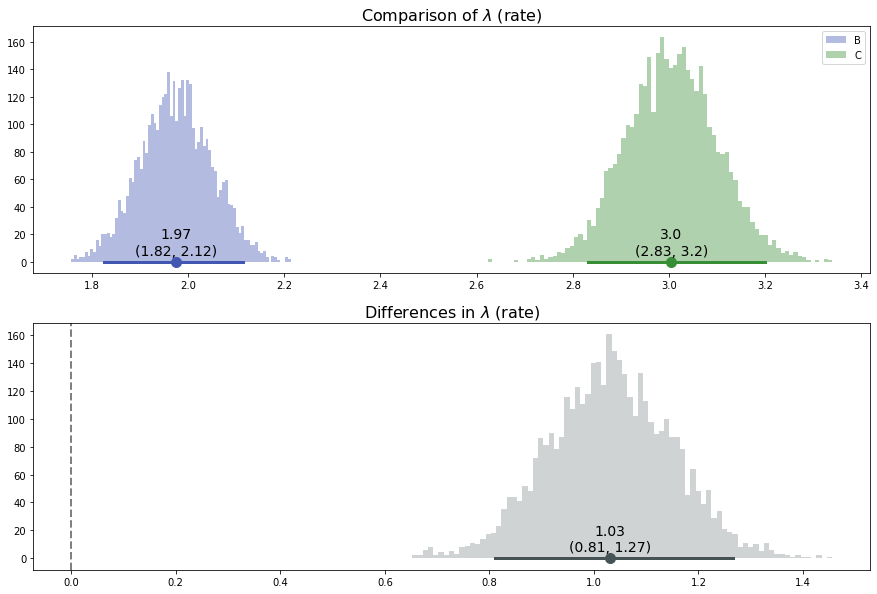

In [30]:
bayesian_poisson_ab_test = poisson_ab_test.copy(inference_method='gamma_poisson')

# Run the test with an alpha of 0.5; get back a HypothesisTestResults object
bayesian_poisson_ab_test_results = exper.run_test(bayesian_poisson_ab_test)

# Check the test results decision
bayesian_poisson_ab_test_results.display()
bayesian_poisson_ab_test_results.visualize()

Note here that samples Bayesian model provide similar central tendency interval estimates to those calculated by the analytical rates ratio model. However, unlike the rates ratio model which looks at the ratio of central tendencies, the Bayesian AB tests provides _deltas_ or differences amongst the rate parameter samples. Thus differences in $\lambda$ far away from zero (in this case the diffence in approximately one) indicate significant difference between the treatments when interpreting the Bayesian counts AB test.